In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
# --- Cargar el dataset ENRIQUECIDO ---
DATA_PATH = '../data/processed/featured_player_dataset.csv'
df = pd.read_csv(DATA_PATH)

print("Dataset enriquecido cargado. Dimensiones:", df.shape)
df.info()


Dataset enriquecido cargado. Dimensiones: (6280, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6280 entries, 0 to 6279
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   player_id                   6280 non-null   int64  
 1   name                        6280 non-null   object 
 2   age                         6280 non-null   float64
 3   position                    6280 non-null   object 
 4   sub_position                6280 non-null   object 
 5   height_in_cm                6228 non-null   float64
 6   country_of_citizenship      6084 non-null   object 
 7   current_club_name           6280 non-null   object 
 8   contract_expiration_date    5504 non-null   object 
 9   goals                       6280 non-null   int64  
 10  assists                     6280 non-null   int64  
 11  minutes_played              6280 non-null   int64  
 12  games_played                6280 non-

In [3]:
# =============================================================================
# 1. Definir Features (X) y Target (y)
# =============================================================================

# El target sigue siendo el mismo
TARGET = 'market_value_in_eur'

# Las features son todas las columnas numéricas EXCEPTO el target y los IDs
# También excluimos features "brutas" que ya hemos normalizado
cols_to_exclude = [
    'player_id', TARGET, 'goals', 'assists', 'minutes_played', 'games_played', # IDs y features brutas
    # Columnas de texto o fecha que no son features directas
    'name', 'position', 'sub_position', 'country_of_citizenship', 
    'current_club_name', 'contract_expiration_date', 'valuation_date'
]

features = [col for col in df.columns if col not in cols_to_exclude]

# Asegurarnos de que todas las features son numéricas
X = df[features].select_dtypes(include=np.number)
y = df[TARGET]

# Aplicamos la transformación logarítmica que ya conocemos
y_log = np.log1p(y)

print(f"Número de features seleccionadas: {len(X.columns)}")
print("Features:", X.columns.tolist())

Número de features seleccionadas: 7
Features: ['age', 'height_in_cm', 'minutes_per_90', 'goals_per_90', 'assists_per_90', 'goals_plus_assists_per_90', 'contract_months_remaining']


In [4]:
# =============================================================================
# 2. Entrenar el Modelo LightGBM
# =============================================================================

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Instanciar el modelo LightGBM Regressor
# Usamos parámetros básicos por ahora. La optimización vendrá después.
lgbm = lgb.LGBMRegressor(random_state=42)

print("\nEntrenando modelo LightGBM...")
lgbm.fit(X_train, y_train_log)
print("Entrenamiento completado.")



Entrenando modelo LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 7
[LightGBM] [Info] Start training from score 14.224265
Entrenamiento completado.


In [5]:
# =============================================================================
# 3. Evaluar y Comparar con el Baseline
# =============================================================================

# Predecir en la escala logarítmica
preds_log = lgbm.predict(X_test)

# Revertir la transformación para interpretar el error en Euros
y_test_eur = np.expm1(y_test_log)
preds_eur = np.expm1(preds_log)

# Calcular métricas
mae_lgbm = mean_absolute_error(y_test_eur, preds_eur)
baseline_mae = 3982015  # El resultado de nuestro notebook anterior

print("\n--- ¡Resultados de la Evaluación! ---")
print(f"MAE Baseline (Ridge): €{baseline_mae:,.0f}")
print(f"MAE Nuevo Modelo (LightGBM): €{mae_lgbm:,.0f}")

improvement = baseline_mae - mae_lgbm
improvement_percent = (improvement / baseline_mae) * 100

print("\n--- Comparación ---")
if improvement > 0:
    print(f"¡Mejora conseguida! El nuevo modelo es €{improvement:,.0f} más preciso.")
    print(f"Esto representa una reducción del error del {improvement_percent:.2f}%.")
else:
    print(f"No se ha conseguido una mejora. El nuevo modelo es €{-improvement:,.0f} menos preciso.")


--- ¡Resultados de la Evaluación! ---
MAE Baseline (Ridge): €3,982,015
MAE Nuevo Modelo (LightGBM): €3,237,352

--- Comparación ---
¡Mejora conseguida! El nuevo modelo es €744,663 más preciso.
Esto representa una reducción del error del 18.70%.



--- Analizando la Importancia de las Características ---


C:\Users\Manu\AppData\Local\Temp\ipykernel_24100\862753581.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_15_features, palette='viridis')


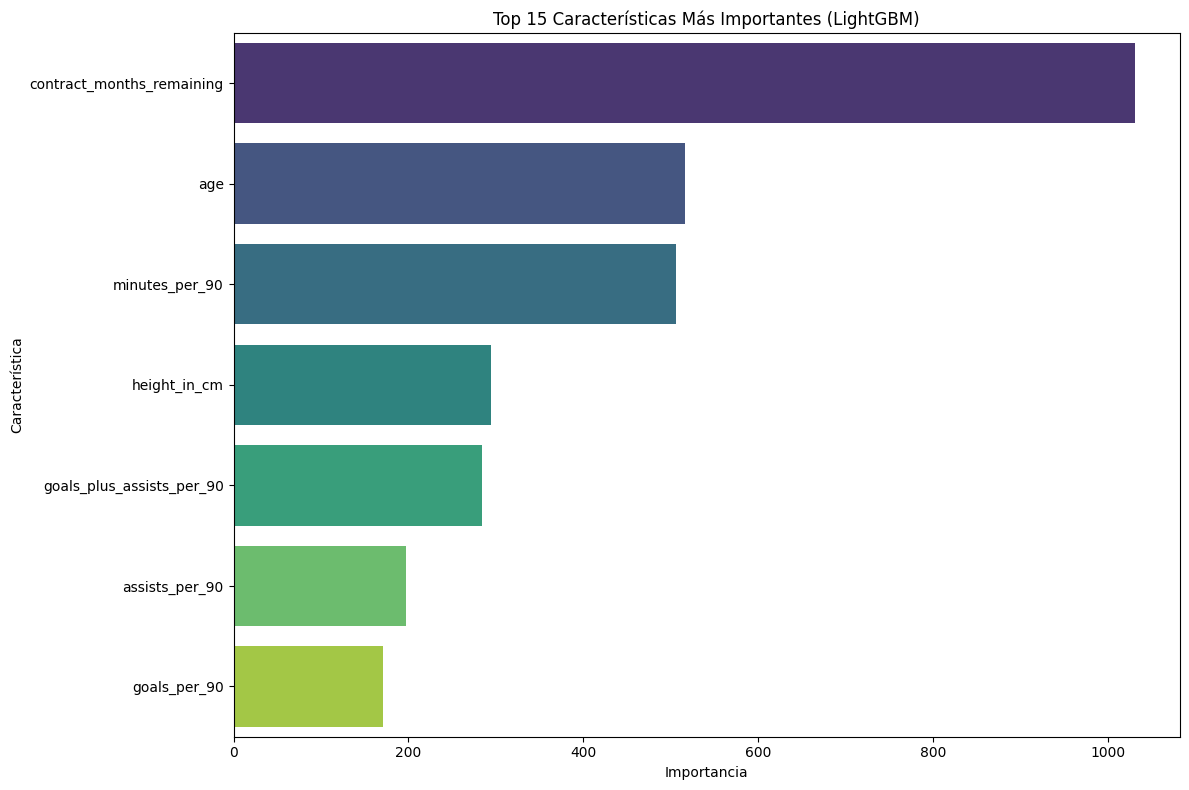


Top 10 características más influyentes:
                     feature  importance
6  contract_months_remaining        1031
0                        age         516
2             minutes_per_90         506
1               height_in_cm         295
5  goals_plus_assists_per_90         284
4             assists_per_90         197
3               goals_per_90         171


In [6]:
# =============================================================================
# 4. Analizar la Importancia de las Características
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Analizando la Importancia de las Características ---")

# Crear un DataFrame con la importancia de cada feature
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_,
}).sort_values('importance', ascending=False)

# Mostrar las 15 más importantes
top_15_features = feature_importances.head(15)

# Visualizar
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_15_features, palette='viridis')
plt.title('Top 15 Características Más Importantes (LightGBM)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Imprimir el top 10 para referencia
print("\nTop 10 características más influyentes:")
print(top_15_features)